<a href="https://colab.research.google.com/github/marcellosusanto11/Tugas-Deep-Learning/blob/master/predict_cloth_type/modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# Set working directory
%cd drive/My\ Drive/Colab\ Notebooks/Tugas\ Deep \Learning

/content/drive/My Drive/Colab Notebooks/Tugas Deep Learning


In [0]:
# Install package
!pip install torch

In [0]:
# Setting general package
import pandas as pd
import pandas_profiling as pp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

# Setting specific package
import struct
import numpy as np
import torch

from matplotlib.pylab import rcParams
# For every plotting cell use this
# grid = gridspec.GridSpec(n_row,n_col)
# ax = plt.subplot(grid[i])
# fig, axes = plt.subplots()
rcParams['figure.figsize'] = [10,5]
plt.style.use('fivethirtyeight') 
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.options.display.float_format = '{:.4f}'.format

## Identify Clothes Type using ANN
This experiment purpose is to learn more about the mechanic of fully-connected neural network. Because of that we will not use a popular package such as Keras to build our ANN model. Instead we will make our own NeuralNetwork class with all the component code from scratch. 

<br> We have 60000 training dataset and 10000 testing dataset consisting of 28x28 pixel image of clothes with the label representing the clothes type. We want to build an ANN model that will receive image as an input and predict what type of cloth for each image. We will use 4 combination of activation function and loss function. For each combinaton we will find the optimal learning rate, scaler, and the option to increase the total of neuorn in each hidden layer or increase the total of the hidden layer if its necessary

<br> Inspiration :
- https://towardsdatascience.com/neural-networks-from-scratch-easy-vs-hard-b26ddc2e89c7
- https://towardsdatascience.com/understand-data-normalization-in-machine-learning-8ff3062101f0

In [0]:
# Function to load our dataset
def read_idx(filename):
    with open(filename, "rb") as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
    
# Load dataset    
x_train_old = read_idx("train-images-idx3-ubyte")
y_train_old = read_idx("train-labels-idx1-ubyte")
x_test_old  = read_idx("test-images-idx3-ubyte")
y_test_old  = read_idx("test-labels-idx1-ubyte")

In [0]:
# Check the dimension of the dataset
print('Ukuran prediktor train :',x_train_old.shape) 
print('Ukuran respon train :',y_train_old.shape)
print('Ukuran prediktor test :',x_test_old.shape) 
print('Ukuran respon test :',y_test_old.shape)

Ukuran prediktor train : (60000, 28, 28)
Ukuran respon train : (60000,)
Ukuran prediktor test : (10000, 28, 28)
Ukuran respon test : (10000,)


In [0]:
# Change the dimension of the training dataset from (60000, 28, 28) to (60000, 784)
x_train = []
for x in x_train_old:
    x_train.append(x.flatten())
x_train = np.array(x_train)

# Change the dimension of the testing dataset from (10000, 28, 28) to (10000, 784)
x_test = []
for x in x_test_old:
    x_test.append(x.flatten())
x_test = np.array(x_test)

In [0]:
# Check the dimension of the dataset now
print('Ukuran prediktor train :',x_train.shape) 
print('Ukuran prediktor test :',x_test.shape) 

Ukuran prediktor train : (60000, 784)
Ukuran prediktor test : (10000, 784)


In [0]:
# One-hot encodes the response variable
y_train = np.eye(y_train_old.max()+1)[y_train_old]
y_test = np.eye(y_test_old.max()+1)[y_test_old]

In [0]:
# Check the dimension of the response variable now
print("Ukuran variabel respon train :",y_train.shape)
print("Ukuran variabel respon test :",y_test.shape)

Ukuran variabel respon train : (60000, 10)
Ukuran variabel respon test : (10000, 10)


In [0]:
# Labels dictionary
label = {0: 'T-shirt/top',
         1: 'Trouser',
         2: 'Pullover',
         3: 'Dress',
         4: 'Coat',
         5: 'Sandal',
         6: 'Shirt',
         7: 'Sneaker',
         8: 'Bag',
         9: 'Ankle boot'}

In [0]:
x_train[0].shape

(784,)

In [0]:
## Activation Function

# Sigmoid
def sigmoid(s) :
  return 1 / (1 + torch.exp(-s))

# Derivate of Sigmoid
def der_sigmoid(s) :
  return s * (1 - s)

# Derivative of MSE based on Sigmoid
def der_sigmoid_mse(s, y) :
  return (s - y) * s * (1 - s)
  
# Tanh
def tanh(s) :
  return torch.tanh(s)

# Derivate of Tanh
def der_tanh(s) :
  return 1 - s**2

# Softmax
def softmax(s) :
  exps = torch.exp(s - torch.max(s, axis = 1, keepdims = True)[0])
  return exps / torch.sum(exps, axis = 1, keepdims = True)

# Derivative of Softmax based on Cross Entropy
def der_softmax_ce(s, y) :
  return s - y

In [0]:
np.array(x_train).shape

(60000, 784)

In [0]:
# Make ANN Class
class NeuralNetwork() :

  # Variable initiation
  def __init__(self, x, y, hl_act, ol_act, der_hl_act, der_ol_act, hl1_dims=784, hl2_dims=784, alpha=1, scaler=None, plus_hl=False):

    # Variable to do standarization and normalization
    self.maxx  = np.max(x)
    self.minx = np.min(x)
    self.meanx = np.mean(x)
    self.stdx  = np.std(x)

    # Variable to modify the ANN
    self.scaler = scaler #Scale predictor or not
    self.y = torch.from_numpy(y).float().cuda()
    self.alpha = alpha #Learning rate
    self.hl1 = hl1_dims #Total neuron in Hidden Layer I
    self.hl2 = hl2_dims #Total neuron in Hidden Layer II
    self.plus_hl = plus_hl #Wether to add new Hiden Layer or not

    # Define activation function used in this model
    self.hl_act = hl_act
    self.ol_act = ol_act
    self.der_hl_act = der_hl_act
    self.der_ol_act = der_ol_act
    
    # Scale the predictor
    self.X = self.make_X(x)
    
    # Initiate seed
    # NIM : 10116017
    torch.manual_seed(10116017)

    # Define dataset dimension
    No = self.y.shape[1]

    # Initiate weight and bias
    self.w0 = torch.randn(784,self.hl1).cuda()
    self.b0 = torch.randn(1,self.hl1).cuda()
    self.w1 = torch.randn(self.hl1,self.hl2).cuda()
    self.b1 = torch.randn(1,self.hl2).cuda()
    if self.plus_hl == True :
      self.w2 = torch.randn(self.hl2,self.hl2).cuda()
      self.b2 = torch.randn(1,self.hl2).cuda()
      self.w3 = torch.randn(self.hl2,No).cuda()
      self.b3 = torch.randn(1,No).cuda()
    else :
      self.w2 = torch.randn(self.hl2,No).cuda()
      self.b2 = torch.randn(1,No).cuda()
    
  # Function to do feature scaling
  def make_X(self, X) :
    if self.scaler == 'norm' :
      # Normalization
      X = (X - self.minx) / (self.maxx - self.minx)
    elif self.scaler == 'standard' :
      # Standarization
      X = (X - self.meanx) / self.stdx

    return torch.from_numpy(X).float().cuda()

  # Function to do forward propagation train
  def forward_train(self):
    self.A0 = self.X

    # Input Layer -> Hidden Layer 1
    Z1      = torch.mm(self.A0, self.w0) + self.b0 
    self.A1 = self.hl_act(Z1)

    # Hidden Layer 1 -> Hidden Layer 2
    Z2      = torch.mm(self.A1, self.w1) + self.b1
    self.A2 = self.hl_act(Z2)

    if self.plus_hl == True :
      # Hidden Layer 2 -> Hidden Layer 3
      Z3      = torch.mm(self.A2, self.w2) + self.b2
      self.A3 = self.hl_act(Z3) 

      # Hidden Layer 3 -> Output Layer
      Z4      = torch.mm(self.A3, self.w3) + self.b3
      self.A4 = self.ol_act(Z4) 

    else :
      # Hidden Layer 2 -> Output Layer
      Z3      = torch.mm(self.A2, self.w2) + self.b2
      self.A3 = self.ol_act(Z3) 

  # Function to do forward propagation predict
  def forward_predict(self):

    # Input Layer -> Hidden Layer 1
    Z1      = torch.mm(self.xs, self.w0) + self.b0 
    self.A1_pred = self.hl_act(Z1)

    # Hidden Layer 1 -> Hidden Layer 2
    Z2      = torch.mm(self.A1_pred, self.w1) + self.b1
    self.A2_pred = self.hl_act(Z2)

    if self.plus_hl == True :
      # Hidden Layer 2 -> Hidden Layer 3
      Z3      = torch.mm(self.A2_pred, self.w2) + self.b2
      self.A3_pred = self.hl_act(Z3) 

      # Hidden Layer 3 -> Output Layer
      Z4      = torch.mm(self.A3_pred, self.w3) + self.b3
      self.A4_pred = self.ol_act(Z4) 

    else :
      # Hidden Layer 2 -> Output Layer
      Z3      = torch.mm(self.A2_pred, self.w2) + self.b2
      self.A3_pred = self.ol_act(Z3) 

  # Function to do backward propagation
  def backward(self):

    if self.plus_hl == True :
      # Derivative of loss function and activation function
      e        = self.der_ol_act(self.A4, self.y)
      delta4   = e/e.shape[0]  # delta_w4
      delta3   = torch.mm(delta4, self.w3.t()) * self.der_hl_act(self.A3) # delta_w3
      delta2   = torch.mm(delta3, self.w2.t()) * self.der_hl_act(self.A2) # delta_w2
      delta1   = torch.mm(delta2, self.w1.t()) * self.der_hl_act(self.A1) # delta_w1

      # Update parameter
      self.w3 -= self.alpha * torch.mm(self.A3.t(), delta4)
      self.b3 -= self.alpha * torch.sum(delta4, axis = 0, keepdims = True)
      self.w2 -= self.alpha * torch.mm(self.A2.t(), delta3)
      self.b2 -= self.alpha * torch.sum(delta3, axis = 0, keepdims = True)
      self.w1 -= self.alpha * torch.mm(self.A1.t(), delta2)
      self.b1 -= self.alpha * torch.sum(delta2, axis = 0, keepdims = True)
      self.w0 -= self.alpha * torch.mm(self.A0.t(), delta1)
      self.b0 -= self.alpha * torch.sum(delta1, axis = 0, keepdims = True)

    else :
      # Derivative of loss function and activation function
      e        = self.der_ol_act(self.A3, self.y)
      delta3   = e/e.shape[0]  # delta_w2
      delta2   = torch.mm(delta3, self.w2.t()) * self.der_hl_act(self.A2) # delta_w1
      delta1   = torch.mm(delta2, self.w1.t()) * self.der_hl_act(self.A1) # delta_w0

      # Update parameter
      self.w2 -= self.alpha * torch.mm(self.A2.t(), delta3)
      self.b2 -= self.alpha * torch.sum(delta3, axis = 0, keepdims = True)
      self.w1 -= self.alpha * torch.mm(self.A1.t(), delta2)
      self.b1 -= self.alpha * torch.sum(delta2, axis = 0, keepdims = True)
      self.w0 -= self.alpha * torch.mm(self.A0.t(), delta1)
      self.b0 -= self.alpha * torch.sum(delta1, axis = 0, keepdims = True)
      
  # Function to predict
  def predict(self,xs):

    # Scaling
    self.xs = self.make_X(xs)

    # Calculate
    self.forward_predict()

    # Predict
    if self.plus_hl == True :
      predict = torch.argmax(self.A4_pred, axis = 1)
    else :
      predict = torch.argmax(self.A3_pred, axis = 1)

    return predict

In [0]:
# Function to compile everything
# Including the viz
def go_ann(ann, X_train, y_train, X_test, y_test, ax, title, iter) :

  # Start time
  from datetime import datetime
  tic = datetime.now()

  # Define list to store accuracy from each epoch
  list_train_acc = []
  list_test_acc = []
  list_epochs = []

  # Iterate to training
  for i in range(epochs):

    # Forward and backward propagation
    ann.forward_train()
    ann.backward()

    # Caclculate accuracy for each iter epoch
    if i%iter == 0:

      # Calculate train accuracy
      prediksi_train = ann.predict(X_train)
      match_train    = np.sum((prediksi_train.cpu().numpy() == np.argmax(y_train, axis = 1))*1)
      akurasi_train  = np.round(np.sum(match_train)/len(y_train)*100, 4)

      # Calculate test accuracy
      prediksi_test = ann.predict(X_test)
      match_test  = np.sum((prediksi_test.cpu().numpy() == np.argmax(y_test, axis = 1))*1)
      akurasi_test = np.round(np.sum(match_test)/len(y_test)*100, 4)

      # Print the output
      print("Iterasi ke :", i,'||','Accuracy Train :',akurasi_train,'||','Accuracy Test :',akurasi_test)
      list_train_acc.append(akurasi_train)
      list_test_acc.append(akurasi_test)
      list_epochs.append(i)

  # End time
  toc = datetime.now()

  # Total time needed to modelling
  print ("Waktu yang diperlukan:", toc-tic)
  print('')

  # Plotting
  ax.plot(list_epochs, list_train_acc, 'o-', label='Train')
  ax.plot(list_epochs, list_test_acc, 'o-', label='Test')
  ax.set_title(title, fontsize=15)
  ax.set_xlabel('Epochs', fontsize=15)
  ax.set_ylabel('Accuracy', fontsize=15)
  ax.legend() ;

  return list_train_acc, list_test_acc, list_epochs

## Combination I
 - Hidden Layer : Sigmoid
 - Output Layer : Softmax
 - Loss Function : Cross Entropy

Iterasi ke : 0 || Accuracy Train : 16.7567 || Accuracy Test : 17.21
Iterasi ke : 500 || Accuracy Train : 79.9867 || Accuracy Test : 76.36
Iterasi ke : 1000 || Accuracy Train : 83.5483 || Accuracy Test : 78.16
Iterasi ke : 1500 || Accuracy Train : 85.435 || Accuracy Test : 78.88
Iterasi ke : 2000 || Accuracy Train : 85.6017 || Accuracy Test : 78.79
Iterasi ke : 2500 || Accuracy Train : 88.4267 || Accuracy Test : 80.08
Iterasi ke : 3000 || Accuracy Train : 89.4767 || Accuracy Test : 80.32
Iterasi ke : 3500 || Accuracy Train : 90.1367 || Accuracy Test : 80.45
Iterasi ke : 4000 || Accuracy Train : 90.1983 || Accuracy Test : 80.34
Iterasi ke : 4500 || Accuracy Train : 91.1067 || Accuracy Test : 80.68
Iterasi ke : 5000 || Accuracy Train : 91.9217 || Accuracy Test : 81.04
Iterasi ke : 5500 || Accuracy Train : 91.525 || Accuracy Test : 80.81
Iterasi ke : 6000 || Accuracy Train : 93.16 || Accuracy Test : 81.1
Iterasi ke : 6500 || Accuracy Train : 93.7483 || Accuracy Test : 81.29
Iterasi ke : 70

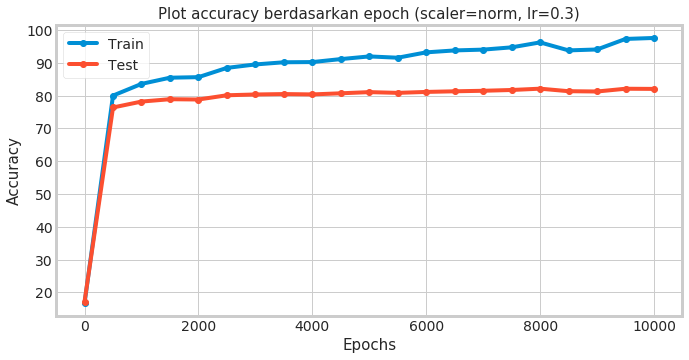

In [0]:
# Plot setting
rcParams['figure.figsize'] = [10,5]
plt.style.use('fivethirtyeight') 
sns.set_style('whitegrid')

# Learning rate modification
list_lr = [0.01, 0.1, 0.3, 0.5, 0.7, 1, 1.5]
list_lr_2 = [0.3]

# Scaler modification
list_scaler = ['None', 'norm', 'standard']
list_scaler_2 = ['norm']

# For subplot
grid = gridspec.GridSpec(1,len(list_scaler_2))
list_df = []

for j,mod in enumerate(list_scaler_2) :

  # Define variable and model parameter
  X_train = np.array(x_train)
  y_train = np.array(y_train)
  X_test = np.array(x_test)
  y_test = np.array(y_test)
  act_func_hidden_layer = sigmoid
  act_func_output_layer = softmax
  der_act_func_hidden_layer = der_sigmoid
  der_act_func_output_layer = der_softmax_ce
  alpha = 0.3
  scaler = mod
  epochs = 10001
  ax = plt.subplot(grid[j])
  ax_title = 'Plot accuracy berdasarkan epoch (scaler=' + scaler + ', lr=' + str(alpha) + ')'

  # Modelling
  ann_v1 = NeuralNetwork(x = X_train, y = y_train
                    ,hl_act = act_func_hidden_layer
                    ,ol_act = act_func_output_layer
                    ,der_hl_act = der_act_func_hidden_layer
                    ,der_ol_act = der_act_func_output_layer
                    ,alpha = alpha
                    ,scaler = scaler)

  # Go
  train_acc, test_acc, epo = go_ann(ann_v1, X_train, y_train, X_test, y_test, ax, ax_title, 500)

  # Make dataframe
  df = pd.DataFrame({'Train Acc':train_acc, 'Test Acc':test_acc, 'Epoch':epo})

  plt.tight_layout()

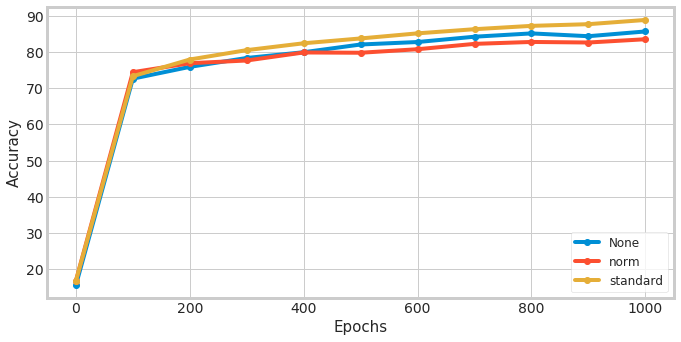

In [0]:
# Make single plot to compare the training accuracy for each modification

# Setting plotting
rcParams['figure.figsize'] = [10,5]
plt.style.use('fivethirtyeight') 
sns.set_style('whitegrid')

for i,df in enumerate(list_df) :
  list_acc = df['Train Acc']
  list_epoch = df['Epoch']

  # Plotting
  lr_title = 'lr='+str(list_lr[i])
  scale_title = list_scaler[i]
  plt.plot(list_epoch, list_acc, 'o-', label=scale_title)
  plt.xlabel('Epochs', fontsize=15)
  plt.ylabel('Accuracy', fontsize=15)
  plt.legend(prop={'size':12}) ;

# Combination II
 - Hidden Layer : Tanh
 - Output Layer : Softmax
 - Loss Function : Cross Entropy

Iterasi ke : 0 || Accuracy Train : 14.6017 || Accuracy Test : 14.06
Iterasi ke : 500 || Accuracy Train : 73.5167 || Accuracy Test : 71.44
Iterasi ke : 1000 || Accuracy Train : 76.1283 || Accuracy Test : 73.27
Iterasi ke : 1500 || Accuracy Train : 78.4317 || Accuracy Test : 74.63
Iterasi ke : 2000 || Accuracy Train : 80.2367 || Accuracy Test : 75.11
Iterasi ke : 2500 || Accuracy Train : 82.2283 || Accuracy Test : 75.4
Iterasi ke : 3000 || Accuracy Train : 84.92 || Accuracy Test : 75.95
Iterasi ke : 3500 || Accuracy Train : 86.9867 || Accuracy Test : 75.93
Iterasi ke : 4000 || Accuracy Train : 86.59 || Accuracy Test : 75.49
Iterasi ke : 4500 || Accuracy Train : 88.885 || Accuracy Test : 76.38
Iterasi ke : 5000 || Accuracy Train : 89.5167 || Accuracy Test : 76.44
Iterasi ke : 5500 || Accuracy Train : 89.7883 || Accuracy Test : 76.18
Iterasi ke : 6000 || Accuracy Train : 90.3717 || Accuracy Test : 76.31
Iterasi ke : 6500 || Accuracy Train : 90.6167 || Accuracy Test : 76.24
Iterasi ke : 700

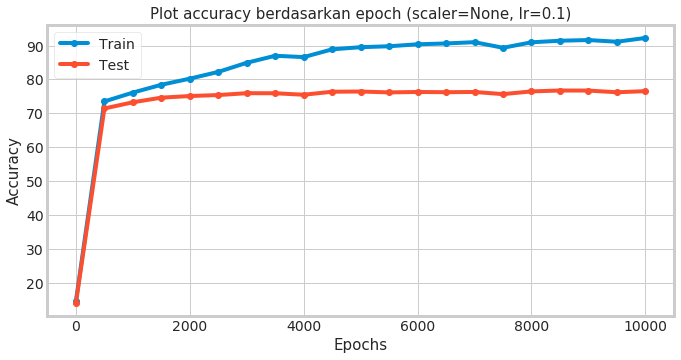

In [0]:
# Plot setting
rcParams['figure.figsize'] = [10,5]
plt.style.use('fivethirtyeight') 
sns.set_style('whitegrid')

# Learning rate modification
list_lr = [0.01, 0.1, 0.3, 0.5, 0.7, 1, 1.5]
list_lr_2 = [0.1, 0.3, 0.5]

# Scaler modification
list_scaler = ['None', 'norm', 'standard']
list_scaler_2 = ['None']

# For subplot
grid = gridspec.GridSpec(1,len(list_scaler_2))
list_df = []

for j,mod in enumerate(list_scaler_2) :

  # Define variable and model parameter
  X_train = np.array(x_train)
  y_train = np.array(y_train)
  X_test = np.array(x_test)
  y_test = np.array(y_test)
  act_func_hidden_layer = tanh
  act_func_output_layer = softmax
  der_act_func_hidden_layer = der_tanh
  der_act_func_output_layer = der_softmax_ce
  alpha = 0.1
  scaler = mod
  epochs = 10001
  ax = plt.subplot(grid[j])
  ax_title = 'Plot accuracy berdasarkan epoch (scaler=' + scaler + ', lr=' + str(alpha) + ')'

  # Modellin
  ann_v1 = NeuralNetwork(x = X_train, y = y_train
                    ,hl_act = act_func_hidden_layer
                    ,ol_act = act_func_output_layer
                    ,der_hl_act = der_act_func_hidden_layer
                    ,der_ol_act = der_act_func_output_layer
                    ,alpha = alpha
                    ,scaler = scaler)

  # Go
  train_acc, test_acc, epo = go_ann(ann_v1, X_train, y_train, X_test, y_test, ax, ax_title, 500)

  # Make dataframe
  df = pd.DataFrame({'Train Acc':train_acc, 'Test Acc':test_acc, 'Epoch':epo})

  # Store dataframe to list
  list_df.append(df)

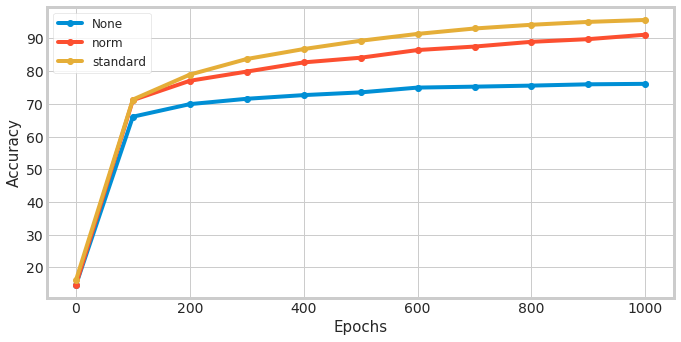

In [0]:
# Make single plot to compare the training accuracy for each modification

# Setting plotting
rcParams['figure.figsize'] = [10,5]
plt.style.use('fivethirtyeight') 
sns.set_style('whitegrid')

for i,df in enumerate(list_df) :
  list_acc = df['Train Acc']
  list_epoch = df['Epoch']

  # Plotting
  #lr_title = 'lr='+str(list_lr_2[i])
  scale_title = list_scaler[i]
  plt.plot(list_epoch, list_acc, 'o-', label=scale_title)
  plt.xlabel('Epochs', fontsize=15)
  plt.ylabel('Accuracy', fontsize=15)
  plt.legend(prop={'size':12}) ;

# Combination III
 - Hidden Layer : Sigmoid
 - Output Layer : Sigmoid
 - Loss Function : MSE

Iterasi ke : 0 || Accuracy Train : 9.7517 || Accuracy Test : 9.49
Iterasi ke : 100 || Accuracy Train : 15.2967 || Accuracy Test : 15.7
Iterasi ke : 200 || Accuracy Train : 16.89 || Accuracy Test : 17.3
Iterasi ke : 300 || Accuracy Train : 21.1183 || Accuracy Test : 21.02
Iterasi ke : 400 || Accuracy Train : 21.8467 || Accuracy Test : 21.86
Iterasi ke : 500 || Accuracy Train : 22.13 || Accuracy Test : 22.21
Iterasi ke : 600 || Accuracy Train : 22.395 || Accuracy Test : 22.44
Iterasi ke : 700 || Accuracy Train : 22.5883 || Accuracy Test : 22.6
Iterasi ke : 800 || Accuracy Train : 22.9933 || Accuracy Test : 22.97
Iterasi ke : 900 || Accuracy Train : 23.7717 || Accuracy Test : 23.79
Iterasi ke : 1000 || Accuracy Train : 25.2967 || Accuracy Test : 24.88
Waktu yang diperlukan: 0:01:49.089985

Iterasi ke : 0 || Accuracy Train : 12.8817 || Accuracy Test : 12.31
Iterasi ke : 100 || Accuracy Train : 22.5867 || Accuracy Test : 22.4
Iterasi ke : 200 || Accuracy Train : 25.34 || Accuracy Test : 24.

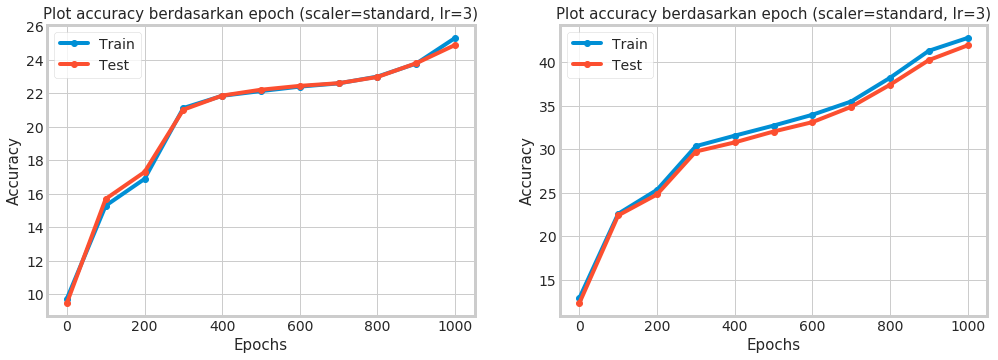

In [0]:
# Plot setting
rcParams['figure.figsize'] = [15,5]
plt.style.use('fivethirtyeight') 
sns.set_style('whitegrid')

# Learning rate modification
list_lr = [0.01, 0.1, 0.3, 0.5, 0.7, 1, 1.5]
list_lr_2 = [2.5, 3]

# Scaler modification
list_scaler = ['None', 'norm', 'standard']
list_scaler_2 = ['standard']

# Total neuron modification
list_neuron = [784, 980, 1176, 1372, 1568]

# Add Hidden Layer or not modification
list_hl = [True, False]

# For subplot
grid = gridspec.GridSpec(1,len(list_hl))
list_df = []

for j,mod in enumerate(list_hl) :

  # Define variable and model parameter
  X_train = np.array(x_train)
  y_train = np.array(y_train)
  X_test = np.array(x_test)
  y_test = np.array(y_test)
  act_func_hidden_layer = sigmoid
  act_func_output_layer = sigmoid
  der_act_func_hidden_layer = der_sigmoid
  der_act_func_output_layer = der_sigmoid_mse
  alpha = 3
  scaler = 'standard'
  epochs = 1001
  ax = plt.subplot(grid[j])
  ax_title = 'Plot accuracy berdasarkan epoch (scaler=' + scaler + ', lr=' + str(alpha) + ')'

  # Modelling
  ann_v3 = NeuralNetwork(x = X_train, y = y_train
                    ,hl_act = act_func_hidden_layer
                    ,ol_act = act_func_output_layer
                    ,der_hl_act = der_act_func_hidden_layer
                    ,der_ol_act = der_act_func_output_layer
                    ,hl1_dims = 784, hl2_dims = 784
                    ,alpha = alpha
                    ,scaler = scaler
                    ,plus_hl=mod)

  # Go
  train_acc, test_acc, epo = go_ann(ann_v3, X_train, y_train, X_test, y_test, ax, ax_title, 100)

  # Make dataframe
  df = pd.DataFrame({'Train Acc':train_acc, 'Test Acc':test_acc, 'Epoch':epo})

  # Store dataframe to list
  list_df.append(df)

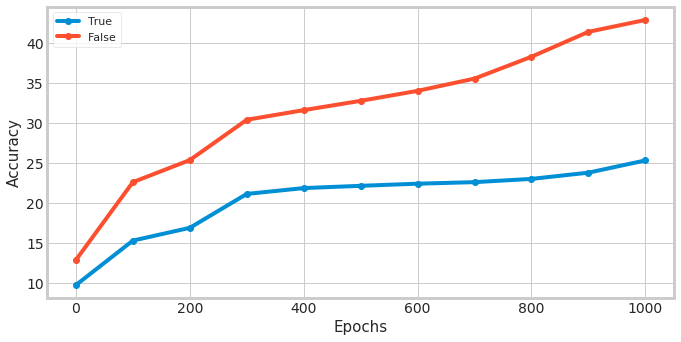

In [0]:
# Make single plot to compare the training accuracy for each modification

# Setting plotting
rcParams['figure.figsize'] = [10,5]
plt.style.use('fivethirtyeight') 
sns.set_style('whitegrid')

for i,df in enumerate(list_df) :
  list_acc = df['Train Acc']
  list_epoch = df['Epoch']

  # Plotting
  #lr_title = 'lr='+str(list_lr_2[i])
  #scale_title = list_scaler[i]
  #neuron_title = list_neuron[i]
  hl_title = list_hl[i]
  plt.plot(list_epoch, list_acc, 'o-', label=hl_title)
  plt.xlabel('Epochs', fontsize=15)
  plt.ylabel('Accuracy', fontsize=15)
  plt.legend(prop={'size':11}) ;

# Combination IV
 - Hidden Layer : Tanh
 - Output Layer : Sigmoid
 - Loss Function : MSE

Iterasi ke : 0 || Accuracy Train : 10.69 || Accuracy Test : 10.78
Iterasi ke : 500 || Accuracy Train : 44.0883 || Accuracy Test : 40.69
Iterasi ke : 1000 || Accuracy Train : 49.8917 || Accuracy Test : 46.56
Iterasi ke : 1500 || Accuracy Train : 53.49 || Accuracy Test : 49.95
Iterasi ke : 2000 || Accuracy Train : 55.24 || Accuracy Test : 51.34
Iterasi ke : 2500 || Accuracy Train : 56.32 || Accuracy Test : 52.46
Iterasi ke : 3000 || Accuracy Train : 57.1433 || Accuracy Test : 53.16
Iterasi ke : 3500 || Accuracy Train : 57.795 || Accuracy Test : 53.53
Iterasi ke : 4000 || Accuracy Train : 58.2883 || Accuracy Test : 53.94
Iterasi ke : 4500 || Accuracy Train : 58.7617 || Accuracy Test : 54.47
Iterasi ke : 5000 || Accuracy Train : 59.1483 || Accuracy Test : 54.85
Iterasi ke : 5500 || Accuracy Train : 59.5433 || Accuracy Test : 55.21
Iterasi ke : 6000 || Accuracy Train : 59.935 || Accuracy Test : 55.54
Iterasi ke : 6500 || Accuracy Train : 60.1867 || Accuracy Test : 55.81
Iterasi ke : 7000 ||

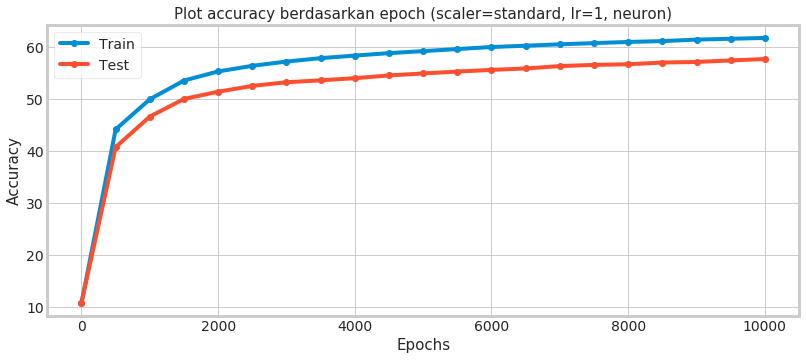

In [0]:
# Plot setting
rcParams['figure.figsize'] = [12,5]
plt.style.use('fivethirtyeight') 
sns.set_style('whitegrid')

# Learning rate modification
list_lr = [0.01, 0.1, 0.3, 0.5, 0.7, 1, 1.5]
list_lr_2 = [2.5, 3]

# Scaler modification
list_scaler = ['None', 'norm', 'standard']
list_scaler_2 = ['standard']

# Total neuron modification
list_neuron = [784, 980]

# Add Hidden Layer or not modification
list_hl = [True, False]
list_hl_2 = [False]

# For subplot
grid = gridspec.GridSpec(1,len(list_hl_2))
list_df = []

for j,mod in enumerate(list_hl_2) :

  # Define variable and model parameter
  X_train = np.array(x_train)
  y_train = np.array(y_train)
  X_test = np.array(x_test)
  y_test = np.array(y_test)
  act_func_hidden_layer = tanh
  act_func_output_layer = sigmoid
  der_act_func_hidden_layer = der_tanh
  der_act_func_output_layer = der_sigmoid_mse
  alpha = 1
  scaler = 'standard'
  epochs = 10001
  ax = plt.subplot(grid[j])
  ax_title = 'Plot accuracy berdasarkan epoch (scaler=' + scaler + ', lr=' + str(alpha) + ', neuron'')'

  # Modelling
  ann_v4 = NeuralNetwork(x = X_train, y = y_train
                    ,hl_act = act_func_hidden_layer
                    ,ol_act = act_func_output_layer
                    ,der_hl_act = der_act_func_hidden_layer
                    ,der_ol_act = der_act_func_output_layer
                    ,hl1_dims = 980, hl2_dims = 980
                    ,alpha = alpha
                    ,scaler = scaler
                    ,plus_hl = mod)

  # Go
  train_acc, test_acc, epo = go_ann(ann_v4, X_train, y_train, X_test, y_test, ax, ax_title, 500)

  # Make dataframe
  df = pd.DataFrame({'Train Acc':train_acc, 'Test Acc':test_acc, 'Epoch':epo})

  # Store dataframe to list
  list_df.append(df)

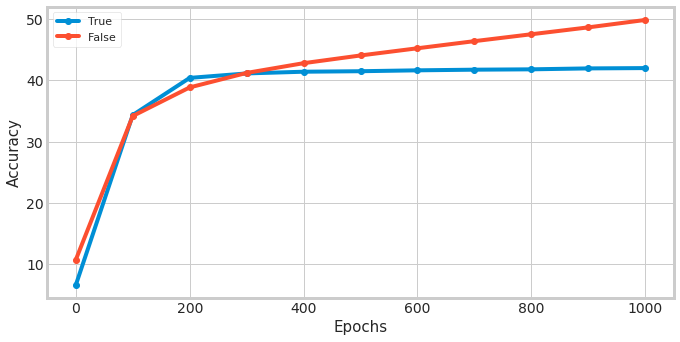

In [0]:
# Make single plot to compare the training accuracy for each modification

# Setting plotting
rcParams['figure.figsize'] = [10,5]
plt.style.use('fivethirtyeight') 
sns.set_style('whitegrid')

for i,df in enumerate(list_df) :
  list_acc = df['Train Acc']
  list_epoch = df['Epoch']

  # Plotting
  #lr_title = 'lr='+str(list_lr_2[i])
  #scale_title = list_scaler[i]
  #neuron_title = list_neuron[i]
  hl_title = list_hl[i]
  plt.plot(list_epoch, list_acc, 'o-', label=hl_title)
  plt.xlabel('Epochs', fontsize=15)
  plt.ylabel('Accuracy', fontsize=15)
  plt.legend(prop={'size':11}) ;